In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import get_scorer_names, confusion_matrix, ConfusionMatrixDisplay, classification_report

from sklearn.impute import SimpleImputer

In [46]:
weed = pd.read_csv("cannabis_full.csv")

## Part One: Binary Classification

In [47]:
sat_or_ind = weed[(weed['Type'] == 'sativa')| (weed['Type'] == 'indica')]
sat_or_ind.head()

,Strain,Type,Rating,Effects,Flavor,Creative,Energetic,Tingly,Euphoric,Relaxed,Aroused,Happy,Uplifted,Hungry,Talkative,Giggly,Focused,Sleepy,Dry,Mouth,Earthy,Sweet,Citrus,Flowery,Violet,Diesel,Spicy/Herbal,Sage,Woody,Apricot,Grapefruit,Orange,Pungent,Grape,Pine,Skunk,Berry,Pepper,Menthol,Blue,Cheese,Chemical,Mango,Lemon,Peach,Vanilla,Nutty,Chestnut,Tea,Tobacco,Tropical,Strawberry,Blueberry,Mint,Apple,Honey,Lavender,Lime,Coffee,Ammonia,Minty,Tree,Fruit,Butter,Pineapple,Tar,Rose,Plum,Pear
2,1024,sativa,4.4,"Uplifted,Happy,Relaxed,Energetic,Creative","Spicy/Herbal,Sage,Woody",1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,3-Bears-Og,indica,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,303-Og,indica,4.2,"Relaxed,Happy,Euphoric,Uplifted,Giggly","Citrus,Pungent,Earthy",0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,3D-Cbd,sativa,4.6,"Uplifted,Focused,Happy,Talkative,Relaxed","Earthy,Woody,Flowery",0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,3X-Crazy,indica,4.4,"Relaxed,Tingly,Happy,Euphoric,Uplifted","Earthy,Grape,Sweet",0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [48]:
data_clean = sat_or_ind.dropna()

In [49]:
X = data_clean.drop(['Strain', 'Type', 'Effects', 'Flavor'], axis = 1)
y = data_clean['Type']

ct = ColumnTransformer(
  [
    ("standardize", StandardScaler(), make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
)

I will be using the scoring metric of f1_macro because it balances precision and recall and averages them across all classes. This is important when there is no target category because going for a balanced metric will insure that there is no preference to one target category.

### Q1: LDA

In [50]:
lda_pipeline = Pipeline([
    ('preprocessing', ct),
    ('lda', LinearDiscriminantAnalysis())
])

param_grid = {
    'lda__solver': ['svd', 'lsqr']
}

lda_grid_search = GridSearchCV(lda_pipeline, param_grid, cv=5, scoring = 'f1_macro')
fitted_pipeline_lda = lda_grid_search.fit(X, y)
best_lda_model = lda_grid_search.best_estimator_

print("Best LDA Parameters:", lda_grid_search.best_params_)

scores = abs(cross_val_score(fitted_pipeline_lda, X, y, cv=5, scoring='f1_macro'))
print(scores.mean())


Best LDA Parameters: {'lda__solver': 'svd'}
Best LDA Parameters: {'lda__solver': 'svd'}


0.8493918971526189
0.8493918971526189


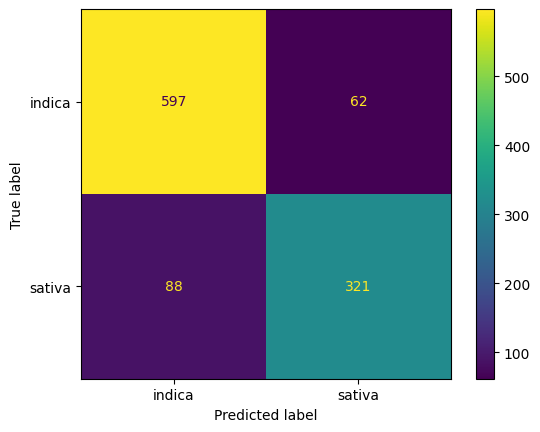

In [51]:
lda_pipeline = Pipeline([
    ('preprocessing', ct),
    ('lda', LinearDiscriminantAnalysis(solver = 'svd'))
])

lda_pipeline.fit(X, y)

#make predictions for confusion matrix
y_preds_lda = cross_val_predict(lda_pipeline, X, y, cv=5)
conf_matrix_lda = confusion_matrix(y, y_preds_lda)
ConfusionMatrixDisplay(confusion_matrix=conf_matrix_lda, display_labels=lda_pipeline.classes_).plot()


### Q2: QDA

In [52]:
import warnings
warnings.filterwarnings("ignore")

qda_pipeline = Pipeline([
    ('preprocessing', ct),
    ('qda', QuadraticDiscriminantAnalysis())
])

param_grid = {
    'qda__reg_param': [0.0, 0.1, 0.2, 0.5, 0.7, 1.0]
}

qda_grid_search = GridSearchCV(qda_pipeline, param_grid, cv=5, scoring = 'f1_macro')
fitted_pipeline_qda = qda_grid_search.fit(X, y)
best_qda_model = qda_grid_search.best_estimator_

print("Best QDA Parameters:", qda_grid_search.best_params_)

scores = abs(cross_val_score(fitted_pipeline_qda, X, y, cv=5, scoring='f1_macro'))
print(scores.mean())

Best QDA Parameters: {'qda__reg_param': 1.0}
Best QDA Parameters: {'qda__reg_param': 1.0}


0.8552499276658413
0.8552499276658413


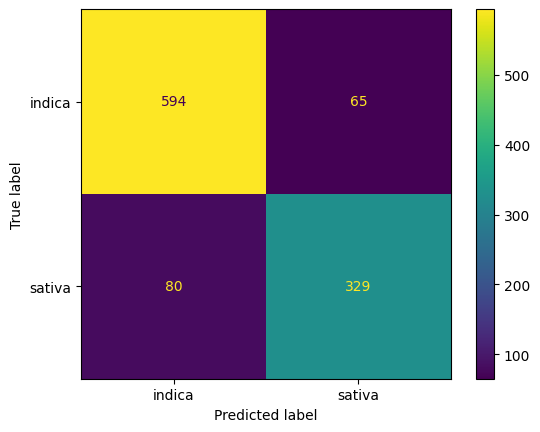

In [53]:
qda_pipeline = Pipeline([
    ('preprocessing', ct),
    ('qda', QuadraticDiscriminantAnalysis(reg_param = 1.0))
])

qda_pipeline.fit(X, y)

#make predictions for confusion matrix
y_preds_qda = cross_val_predict(qda_pipeline, X, y, cv=5)
conf_matrix_qda = confusion_matrix(y, y_preds_qda)
ConfusionMatrixDisplay(confusion_matrix=conf_matrix_qda, display_labels=qda_pipeline.classes_).plot()

### Q3: SVC

In [54]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    "degree": [2, 3, 4],
    'kernel': ['linear', 'rbf'],
    'gamma': [0.001, 0.01, 0.1, 1]
}

svc = SVC()

# Grid Search
grid_search = GridSearchCV(svc, param_grid, cv=5, scoring='f1_macro')
grid_search.fit(X, y)

# Best parameters
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Parameters: {'C': 100, 'degree': 2, 'gamma': 0.001, 'kernel': 'rbf'}
Best Score: 0.8611192766041708
Best Parameters: {'C': 100, 'degree': 2, 'gamma': 0.001, 'kernel': 'rbf'}
Best Score: 0.8611192766041708


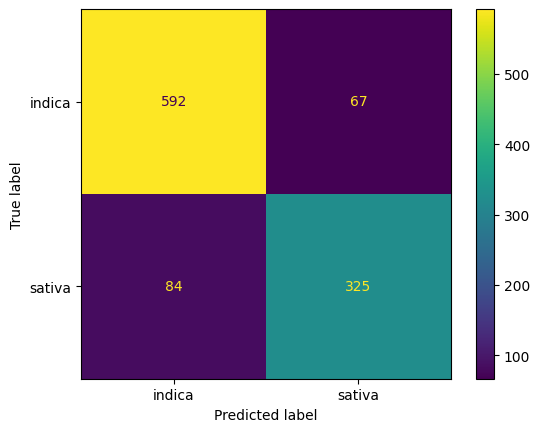

In [55]:
svc_pipeline = Pipeline([
    ('preprocessing', ct),
    ('svc', SVC(C = 100, degree = 2, gamma = 0.001, kernel = "rbf"))
])

svc_pipeline.fit(X, y)

#make predictions for confusion matrix
y_preds_svc = cross_val_predict(svc_pipeline, X, y, cv=5)
conf_matrix_svc = confusion_matrix(y, y_preds_svc)
ConfusionMatrixDisplay(confusion_matrix=conf_matrix_svc, display_labels=svc_pipeline.classes_).plot()

### Q4: SVM

In [56]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'degree': [2, 3, 4],
    'gamma': ['scale', 'auto', 0.01, 0.1],
    'coef0': [0, 1, 10] 
}

svm = SVC(kernel= "poly")

# Grid Search
grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='f1_macro')
grid_search.fit(X, y)

# Best parameters
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Parameters: {'C': 0.1, 'coef0': 10, 'degree': 2, 'gamma': 0.1}
Best Score: 0.8629719344337747
Best Parameters: {'C': 0.1, 'coef0': 10, 'degree': 2, 'gamma': 0.1}
Best Score: 0.8629719344337747


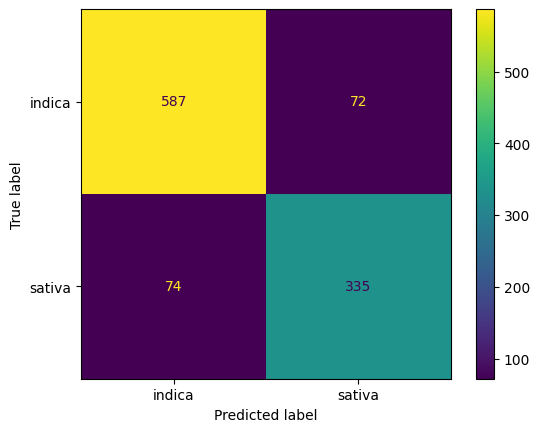

In [57]:
svm_pipeline = Pipeline([
    ('preprocessing', ct),
    ('svm', SVC(kernel = "poly", C = 0.1, coef0 = 10, degree = 2, gamma = 0.1))
])

svm_pipeline.fit(X, y)

#make predictions for confusion matrix
y_preds_svm = cross_val_predict(svm_pipeline, X, y, cv=5)
conf_matrix_svm = confusion_matrix(y, y_preds_svm)
ConfusionMatrixDisplay(confusion_matrix=conf_matrix_svm, display_labels=svm_pipeline.classes_).plot()

## Part Two: Natural Multiclass

In [58]:
weed_cleaned = weed.dropna()
weed_cleaned.head()

,Strain,Type,Rating,Effects,Flavor,Creative,Energetic,Tingly,Euphoric,Relaxed,Aroused,Happy,Uplifted,Hungry,Talkative,Giggly,Focused,Sleepy,Dry,Mouth,Earthy,Sweet,Citrus,Flowery,Violet,Diesel,Spicy/Herbal,Sage,Woody,Apricot,Grapefruit,Orange,Pungent,Grape,Pine,Skunk,Berry,Pepper,Menthol,Blue,Cheese,Chemical,Mango,Lemon,Peach,Vanilla,Nutty,Chestnut,Tea,Tobacco,Tropical,Strawberry,Blueberry,Mint,Apple,Honey,Lavender,Lime,Coffee,Ammonia,Minty,Tree,Fruit,Butter,Pineapple,Tar,Rose,Plum,Pear
0,100-Og,hybrid,4.0,"Creative,Energetic,Tingly,Euphoric,Relaxed","Earthy,Sweet,Citrus",1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,98-White-Widow,hybrid,4.7,"Relaxed,Aroused,Creative,Happy,Energetic","Flowery,Violet,Diesel",1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1024,sativa,4.4,"Uplifted,Happy,Relaxed,Energetic,Creative","Spicy/Herbal,Sage,Woody",1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,13-Dawgs,hybrid,4.2,"Tingly,Creative,Hungry,Relaxed,Uplifted","Apricot,Citrus,Grapefruit",1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,24K-Gold,hybrid,4.6,"Happy,Relaxed,Euphoric,Uplifted,Talkative","Citrus,Earthy,Orange",0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [59]:
X = weed_cleaned.drop(['Strain', 'Type', 'Effects', 'Flavor'], axis = 1)
y = weed_cleaned['Type']

### Q1: Decision Tree

In [60]:
dtree_pipeline = Pipeline([
    ('preprocessing', ct), 
    ('dt', DecisionTreeClassifier())
])

dtree_param_grid = {
    'dt__max_depth': range(1, 11), 
    'dt__min_samples_split': range(2, 11),
    'dt__min_samples_leaf': range(1, 11), 
    'dt__ccp_alpha': [0.001, 0.01, 0.1, 0.2]
}


dtree_grid_search = GridSearchCV(dtree_pipeline, dtree_param_grid, cv=5, scoring='f1_macro', n_jobs=-1)
dtree_grid_search.fit(X, y)

print("Best Decision Tree Parameters:", dtree_grid_search.best_params_)
print("Best Decision Tree Score:", dtree_grid_search.best_score_)

Best Decision Tree Parameters: {'dt__ccp_alpha': 0.001, 'dt__max_depth': 3, 'dt__min_samples_leaf': 1, 'dt__min_samples_split': 2}
Best Decision Tree Score: 0.5848756063204548
Best Decision Tree Parameters: {'dt__ccp_alpha': 0.001, 'dt__max_depth': 3, 'dt__min_samples_leaf': 1, 'dt__min_samples_split': 2}
Best Decision Tree Score: 0.5848756063204548


In [61]:
dtree_pipeline = Pipeline([
    ('preprocessing', ct),
    ('dt', DecisionTreeClassifier(ccp_alpha = 0.001, max_depth = 3, min_samples_leaf = 1, min_samples_split = 2))
])

fitted_pipeline_dtree = dtree_pipeline.fit(X, y)
best_dt_model = fitted_pipeline_dtree.named_steps['dt']

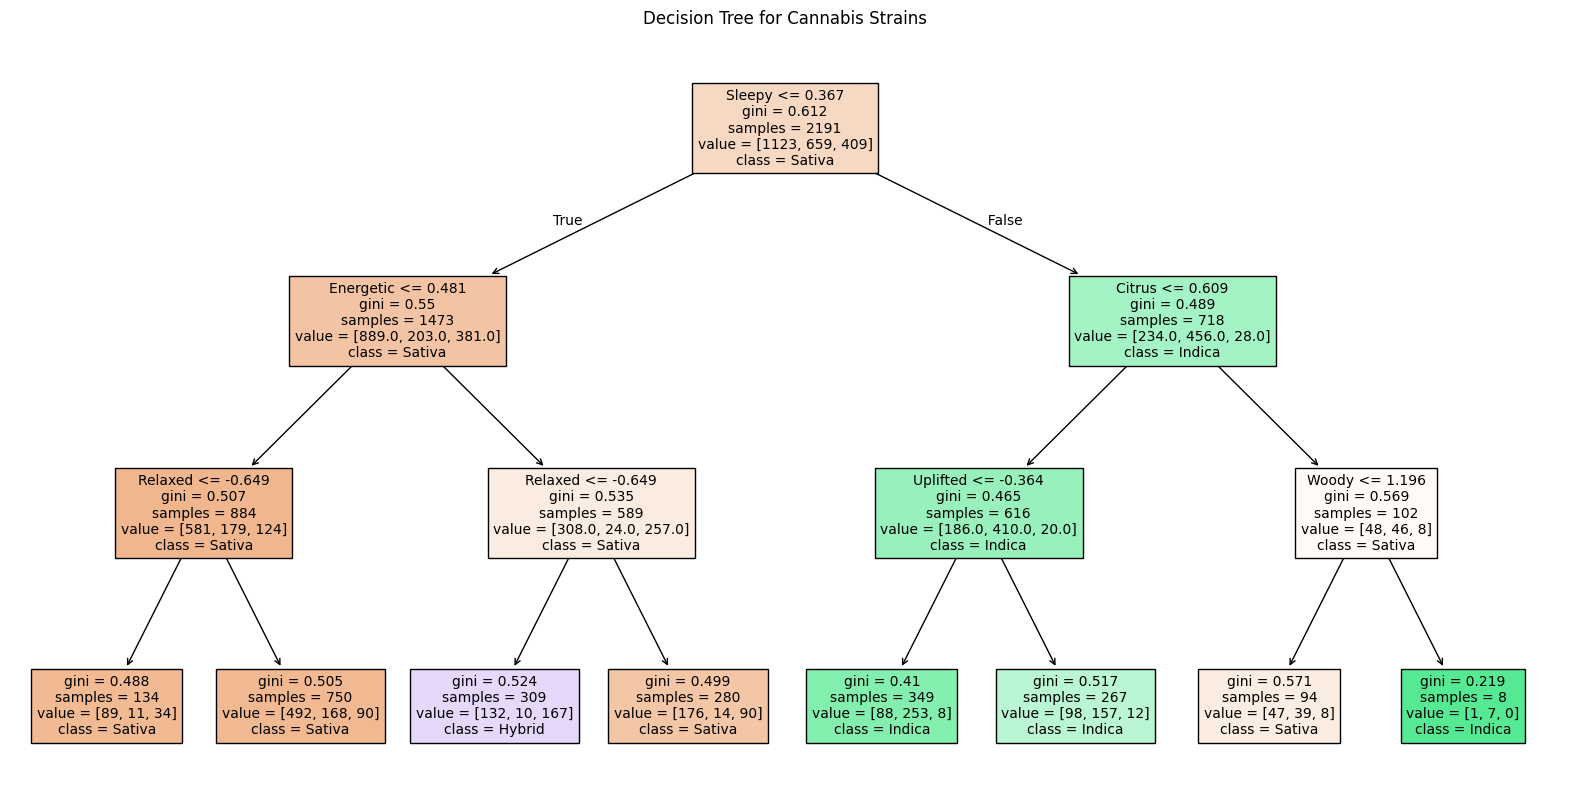

In [62]:
plt.figure(figsize=(20,10))
plot_tree(best_dt_model,
          filled=True,
          feature_names=X.columns,
          class_names=['Sativa', 'Indica', 'Hybrid'],
          max_depth=3,
          fontsize=10)
plt.title("Decision Tree for Cannabis Strains")
plt.show()

This decision tree predicts cannabis strain types (Sativa, Indica, or Hybrid) based on features like "Sleepy," "Energetic," and "Citrus." Strains with low "Sleepy" and "Relaxed" scores are typically classified as Sativa, while those with high "Sleepy" and "Citrus" scores are more likely Indica.

### Q2: LDA, QDA, and KNN

### LDA

In [63]:
lda_pipeline2 = Pipeline([
    ('preprocessing', ct),
    ('lda', LinearDiscriminantAnalysis())
])

param_grid = {
    'lda__solver': ['svd', 'lsqr']
}

lda_grid_search2 = GridSearchCV(lda_pipeline2, param_grid, cv=5, scoring = 'f1_macro')

fitted_pipeline_lda2 = lda_grid_search2.fit(X, y)

best_lda_model2 = lda_grid_search2.best_estimator_

print("Best LDA Parameters:", lda_grid_search2.best_params_)

scores = abs(cross_val_score(fitted_pipeline_lda2, X, y, cv=5, scoring='f1_macro'))
print(scores.mean())

Best LDA Parameters: {'lda__solver': 'svd'}
Best LDA Parameters: {'lda__solver': 'svd'}


0.5959682341948618
0.5959682341948618


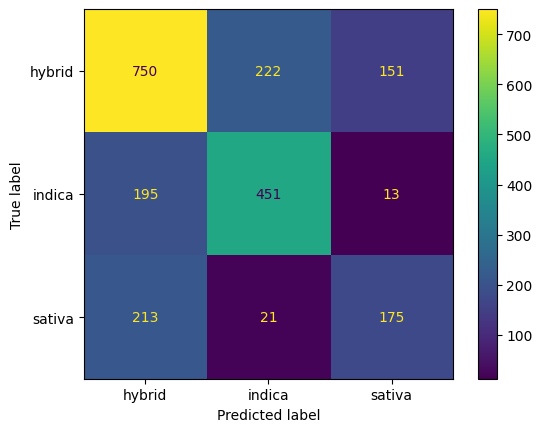

In [64]:
lda_pipeline2 = Pipeline([
    ('preprocessing', ct),
    ('lda', LinearDiscriminantAnalysis(solver = 'svd'))
])

lda_pipeline2.fit(X, y)

#make predictions for confusion matrix
y_preds_lda2 = cross_val_predict(lda_pipeline2, X, y, cv=5)
conf_matrix_lda2 = confusion_matrix(y, y_preds_lda2)
ConfusionMatrixDisplay(confusion_matrix=conf_matrix_lda2, display_labels=lda_pipeline2.classes_).plot()

### QDA

In [65]:
qda_pipeline2 = Pipeline([
    ('preprocessing', ct),
    ('qda', QuadraticDiscriminantAnalysis())
])

param_grid = {
    'qda__reg_param': [0.0, 0.1, 0.2, 0.5, 0.7, 1.0]
}

qda_grid_search2 = GridSearchCV(qda_pipeline2, param_grid, cv=5, scoring = 'f1_macro')
fitted_pipeline_qda2 = qda_grid_search2.fit(X, y)
best_qda_model2 = qda_grid_search2.best_estimator_

print("Best QDA Parameters:", qda_grid_search2.best_params_)

scores = abs(cross_val_score(fitted_pipeline_qda2, X, y, cv=5, scoring='f1_macro'))
print(scores.mean())

Best QDA Parameters: {'qda__reg_param': 1.0}
Best QDA Parameters: {'qda__reg_param': 1.0}


0.6000537665910602
0.6000537665910602


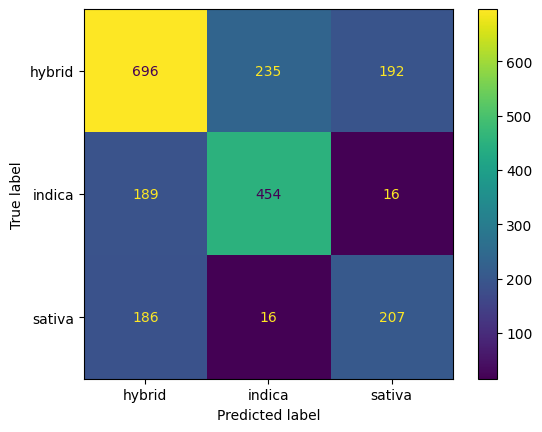

In [66]:
qda_pipeline2 = Pipeline([
    ('preprocessing', ct),
    ('qda', QuadraticDiscriminantAnalysis(reg_param = 1.0))
])

qda_pipeline2.fit(X, y)

#make predictions for confusion matrix
y_preds_qda2 = cross_val_predict(qda_pipeline2, X, y, cv=5)
conf_matrix_qda2 = confusion_matrix(y, y_preds_qda2)
ConfusionMatrixDisplay(confusion_matrix=conf_matrix_qda2, display_labels=qda_pipeline2.classes_).plot()

### KNN

In [67]:
knn_pipeline = Pipeline([
    ('preprocessing', ct),
    ('knn', KNeighborsClassifier())
])

param_grid = {
    'knn__n_neighbors': np.arange(1, 31),
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan']
}

knn_grid_search = GridSearchCV(knn_pipeline, param_grid, cv=5, scoring = 'f1_macro')
fitted_pipeline_knn = knn_grid_search.fit(X, y)
best_knn_model = knn_grid_search.best_estimator_

print("Best KNN Parameters:", knn_grid_search.best_params_)

scores = abs(cross_val_score(fitted_pipeline_knn, X, y, cv=5, scoring='f1_macro'))
print(scores.mean())



Best KNN Parameters: {'knn__metric': 'manhattan', 'knn__n_neighbors': np.int64(11), 'knn__weights': 'distance'}
Best KNN Parameters: {'knn__metric': 'manhattan', 'knn__n_neighbors': np.int64(11), 'knn__weights': 'distance'}


0.49926723514595783
0.49926723514595783


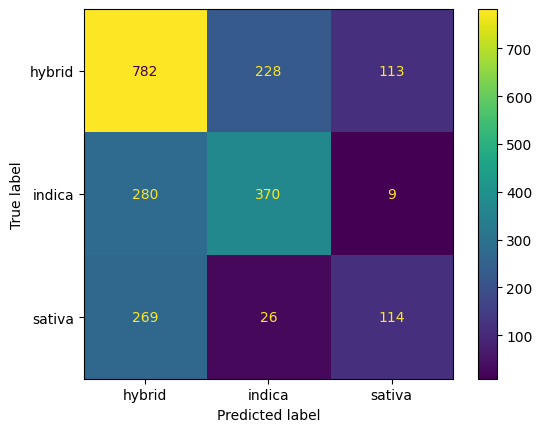

In [68]:
knn_pipeline = Pipeline([
    ('preprocessing', ct),
    ('knn', KNeighborsClassifier(metric = "manhattan", n_neighbors = 11, weights = "distance"))
])

knn_pipeline.fit(X, y)

#make predictions for confusion matrix
y_preds_knn = cross_val_predict(knn_pipeline, X, y, cv=5)
conf_matrix_knn = confusion_matrix(y, y_preds_knn)
ConfusionMatrixDisplay(confusion_matrix=conf_matrix_knn, display_labels=knn_pipeline.classes_).plot()

### Q3
Were your metrics better or worse than in Part One? Why? Which categories were most likely to get mixed up, according to the confusion matrices? Why?



Overall, the f1_macro scores from the Binary Classification models were noticably higher than the Natural Multiclass models. This is expected because it is easier to make Binary Classifications since there are only two categories of "Indica" vs. "Sativa". This two categories also have more distinguishable differences. So when including the new type of "Hybrid", it is harder to correctly distinguish the three types because there are a lot of overlaps between hybrid and the other two types. Looking at the confusion matrices, both Indica and Sativa strains are most commonly being incorrectly predicted as hybrid. This again makes sense because hybrid has qualities that are common with Indica and Sativa strains. 

## Part Three: Multiclass from Binary

### Q1: OvR


In [69]:
new_weed = weed_cleaned.copy()
new_weed['Sativa'] = np.where(new_weed['Type'] == "sativa", 1, 0)
new_weed['Indica'] = np.where(new_weed['Type'] == "indica", 1, 0)
new_weed['Hybrid'] = np.where(new_weed['Type'] == "hybrid", 1, 0)

### Indica vs. Not Indica

In [70]:
X = new_weed.drop(['Strain', 'Type', 'Effects', 'Flavor', 'Sativa', 'Indica','Hybrid'], axis = 1)
y = new_weed['Indica']

In [71]:
logistic_pipeline = Pipeline(
    [("preprocessing", ct),
     ("logistic", LogisticRegression())]
).set_output(transform="pandas")

logistic_pipeline.fit(X, y)

scores = abs(cross_val_score(logistic_pipeline, X, y, cv=5, scoring='f1_macro'))
print(scores.mean())

0.7418938780624698
0.7418938780624698


In [72]:
svc_pipeline = Pipeline(
    [("preprocessing", ct),
     ("svc", SVC())]
).set_output(transform="pandas")

svc_pipeline.fit(X, y)

scores = abs(cross_val_score(svc_pipeline, X, y, cv=5, scoring='f1_macro'))
print(scores.mean())

0.7201806861560669
0.7201806861560669


### Sativa vs. Not Sativa

In [73]:
X = new_weed.drop(['Strain', 'Type', 'Effects', 'Flavor', 'Sativa', 'Indica','Hybrid'], axis = 1)
y = new_weed['Sativa']

In [74]:
logistic_pipeline2 = Pipeline(
    [("preprocessing", ct),
     ("logistic", LogisticRegression())]
).set_output(transform="pandas")

logistic_pipeline2.fit(X, y)

scores = abs(cross_val_score(logistic_pipeline2, X, y, cv=5, scoring='f1_macro'))
print(scores.mean())

0.6472171921891974
0.6472171921891974


In [75]:
svc_pipeline2 = Pipeline(
    [("preprocessing", ct),
     ("svc", SVC())]
).set_output(transform="pandas")

svc_pipeline2.fit(X, y)

scores = abs(cross_val_score(svc_pipeline2, X, y, cv=5, scoring='f1_macro'))
print(scores.mean())

0.5877710733583789
0.5877710733583789


### Hybrid vs. Not Hybrid

In [76]:
X = new_weed.drop(['Strain', 'Type', 'Effects', 'Flavor', 'Sativa', 'Indica','Hybrid'], axis = 1)
y = new_weed['Hybrid']

In [77]:
logistic_pipeline3 = Pipeline(
    [("preprocessing", ct),
     ("logistic", LogisticRegression())]
).set_output(transform="pandas")

logistic_pipeline3.fit(X, y)

scores = abs(cross_val_score(logistic_pipeline3, X, y, cv=5, scoring='f1_macro'))
print(scores.mean())

0.6140879154786848
0.6140879154786848


In [78]:
svc_pipeline3 = Pipeline(
    [("preprocessing", ct),
     ("svc", SVC())]
).set_output(transform="pandas")

svc_pipeline3.fit(X, y)

scores = abs(cross_val_score(svc_pipeline3, X, y, cv=5, scoring='f1_macro'))
print(scores.mean())

0.6124523646862047
0.6124523646862047


### Q2
Which of the six models did the best job distinguishing the target category from the rest? Which did the worst? Does this make intuitive sense?



The model that performed best at distinguishing the target category from the rest of the data was the logistic regression on Indica vs. Not Indica. The model that did the worst was the SVC model on Hybrid vs. Not Hybrid. This makes intuitive sense, since Indica vs. Not Indica has more distinguishable features, while Hybrids share a lot of features with both Indica and Sativa and therefore are harder to differentiate.

### Q3: OvO

In [79]:
weed_ind_sat = new_weed[(new_weed['Type'] == "indica") | (new_weed['Type'] == "sativa")]
weed_ind_hyb = new_weed[(new_weed['Type'] == "indica") | (new_weed['Type'] == "hybrid")]
weed_hyb_sat = new_weed[(new_weed['Type'] == "sativa") | (new_weed['Type'] == "hybrid")]

### Indica vs. Sativa

In [80]:
X = weed_ind_sat.drop(['Strain', 'Type', 'Effects', 'Flavor', 'Sativa', 'Indica','Hybrid'], axis = 1)
y = weed_ind_sat['Type']

In [81]:
logistic_pipeline4 = Pipeline(
    [("preprocessing", ct),
     ("logistic", LogisticRegression())]
).set_output(transform="pandas")

logistic_pipeline4.fit(X, y)

y_preds_log = cross_val_predict(logistic_pipeline4, X, y, cv=5)

scores = abs(cross_val_score(logistic_pipeline4, X, y, cv=5, scoring='f1_macro'))
print(scores.mean())

print("Classification Report:\n", classification_report(y, y_preds_log))

0.8406636977174451
Classification Report:
               precision    recall  f1-score   support

      indica       0.87      0.90      0.88       659
      sativa       0.82      0.78      0.80       409

    accuracy                           0.85      1068
   macro avg       0.85      0.84      0.84      1068
weighted avg       0.85      0.85      0.85      1068

0.8406636977174451
Classification Report:
               precision    recall  f1-score   support

      indica       0.87      0.90      0.88       659
      sativa       0.82      0.78      0.80       409

    accuracy                           0.85      1068
   macro avg       0.85      0.84      0.84      1068
weighted avg       0.85      0.85      0.85      1068



In [82]:
svc_pipeline4 = Pipeline(
    [("preprocessing", ct),
     ("svc", SVC())]
).set_output(transform="pandas")

svc_pipeline4.fit(X, y)

y_preds_svc = cross_val_predict(svc_pipeline4, X, y, cv=5)

scores = abs(cross_val_score(svc_pipeline4, X, y, cv=5, scoring='f1_macro'))
print(scores.mean())

print("Classification Report:\n", classification_report(y, y_preds_svc))

0.8268760004339072
Classification Report:
               precision    recall  f1-score   support

      indica       0.84      0.92      0.88       659
      sativa       0.84      0.72      0.78       409

    accuracy                           0.84      1068
   macro avg       0.84      0.82      0.83      1068
weighted avg       0.84      0.84      0.84      1068

0.8268760004339072
Classification Report:
               precision    recall  f1-score   support

      indica       0.84      0.92      0.88       659
      sativa       0.84      0.72      0.78       409

    accuracy                           0.84      1068
   macro avg       0.84      0.82      0.83      1068
weighted avg       0.84      0.84      0.84      1068



### Indica vs. Hybrid

In [83]:
X = weed_ind_hyb.drop(['Strain', 'Type', 'Effects', 'Flavor', 'Sativa', 'Indica','Hybrid'], axis = 1)
y = weed_ind_hyb['Type']

In [84]:
logistic_pipeline5 = Pipeline(
    [("preprocessing", ct),
     ("logistic", LogisticRegression())]
).set_output(transform="pandas")

logistic_pipeline5.fit(X, y)

y_preds_log = cross_val_predict(logistic_pipeline5, X, y, cv=5)

scores = abs(cross_val_score(logistic_pipeline5, X, y, cv=5, scoring='f1_macro'))
print(scores.mean())

print("Classification Report:\n", classification_report(y, y_preds_log))

0.7247540971681644
Classification Report:
               precision    recall  f1-score   support

      hybrid       0.79      0.81      0.80      1123
      indica       0.66      0.64      0.65       659

    accuracy                           0.75      1782
   macro avg       0.73      0.72      0.72      1782
weighted avg       0.74      0.75      0.74      1782

0.7247540971681644
Classification Report:
               precision    recall  f1-score   support

      hybrid       0.79      0.81      0.80      1123
      indica       0.66      0.64      0.65       659

    accuracy                           0.75      1782
   macro avg       0.73      0.72      0.72      1782
weighted avg       0.74      0.75      0.74      1782



In [85]:
svc_pipeline5 = Pipeline(
    [("preprocessing", ct),
     ("svc", SVC())]
).set_output(transform="pandas")

svc_pipeline5.fit(X, y)

y_preds_svc = cross_val_predict(svc_pipeline5, X, y, cv=5)

scores = abs(cross_val_score(svc_pipeline5, X, y, cv=5, scoring='f1_macro'))
print(scores.mean())

print("Classification Report:\n", classification_report(y, y_preds_svc))

0.7044380176072776
Classification Report:
               precision    recall  f1-score   support

      hybrid       0.77      0.81      0.79      1123
      indica       0.65      0.59      0.62       659

    accuracy                           0.73      1782
   macro avg       0.71      0.70      0.70      1782
weighted avg       0.73      0.73      0.73      1782

0.7044380176072776
Classification Report:
               precision    recall  f1-score   support

      hybrid       0.77      0.81      0.79      1123
      indica       0.65      0.59      0.62       659

    accuracy                           0.73      1782
   macro avg       0.71      0.70      0.70      1782
weighted avg       0.73      0.73      0.73      1782



### Hybrid vs. Sativa

In [86]:
X = weed_hyb_sat.drop(['Strain', 'Type', 'Effects', 'Flavor', 'Sativa', 'Indica','Hybrid'], axis = 1)
y = weed_hyb_sat['Type']

In [87]:
logistic_pipeline6 = Pipeline(
    [("preprocessing", ct),
     ("logistic", LogisticRegression())]
).set_output(transform="pandas")

logistic_pipeline6.fit(X, y)

y_preds_log = cross_val_predict(logistic_pipeline6, X, y, cv=5)

scores = abs(cross_val_score(logistic_pipeline6, X, y, cv=5, scoring='f1_macro'))
print(scores.mean())

print("Classification Report:\n", classification_report(y, y_preds_log))

0.6228351369085744
Classification Report:
               precision    recall  f1-score   support

      hybrid       0.79      0.89      0.84      1123
      sativa       0.54      0.33      0.41       409

    accuracy                           0.74      1532
   macro avg       0.66      0.61      0.62      1532
weighted avg       0.72      0.74      0.72      1532

0.6228351369085744
Classification Report:
               precision    recall  f1-score   support

      hybrid       0.79      0.89      0.84      1123
      sativa       0.54      0.33      0.41       409

    accuracy                           0.74      1532
   macro avg       0.66      0.61      0.62      1532
weighted avg       0.72      0.74      0.72      1532



In [88]:
svc_pipeline6 = Pipeline(
    [("preprocessing", ct),
     ("svc", SVC())]
).set_output(transform="pandas")

svc_pipeline6.fit(X, y)

y_preds_svc = cross_val_predict(svc_pipeline6, X, y, cv=5)

scores = abs(cross_val_score(svc_pipeline6, X, y, cv=5, scoring='f1_macro'))
print(scores.mean())

print("Classification Report:\n", classification_report(y, y_preds_svc))

0.5723277546033707
Classification Report:
               precision    recall  f1-score   support

      hybrid       0.77      0.93      0.84      1123
      sativa       0.52      0.22      0.31       409

    accuracy                           0.74      1532
   macro avg       0.64      0.57      0.58      1532
weighted avg       0.70      0.74      0.70      1532

0.5723277546033707
Classification Report:
               precision    recall  f1-score   support

      hybrid       0.77      0.93      0.84      1123
      sativa       0.52      0.22      0.31       409

    accuracy                           0.74      1532
   macro avg       0.64      0.57      0.58      1532
weighted avg       0.70      0.74      0.70      1532



### Q4
Which of the six models did the best job distinguishing at differentiating the two groups? Which did the worst? Does this make intuitive sense?



The model that performed best was the Logistic Regression on Indica vs. Sativa, while the worst model was the Support Vector Classifier on Hybrid vs. Sativa. This matches our findings from earlier that it is easier to differentiate between Sativa and Indica strands than between Hybrid and either Sativa or Indica strands.

### Q5
Suppose you had simply input the full data, with three classes, into the LogisticRegression function. Would this have automatically taken an “OvO” approach or an “OvR” approach? What about for SVC?



By default, LogisticRegression in scikit-learn uses a One-vs-Rest (OvR) approach for multi-class classification but can use a multinomial approach if specified. SVC, on the other hand, automatically uses a One-vs-One (OvO) approach for multi-class problems.